In [1]:
%matplotlib inline
import time 

from qutip import mesolve, steadystate
#from importlib import reload

import numpy as np
import optical as EM
import phonons as RC
import leads as FL
from utils import *
from photocell_setup import *
import matplotlib.pyplot as plt
from style import *

utils imported


# Designing an experiment to understand non-additivity

The dependence of populations on phonon coupling


## Non-additivity of optical dissipator

different effective transition rates sampling spectral density differently competes with different thermal occupations.


## Non-additivity of lead dissipators

<img src="PLOTS/FermionModel4LS.png" alt="Drawing" style="width: 500px;"/>

- different effective transition frequencies sampling spectral density differently. 
    - Since the maximum coupling is always at the non-additive conduction and (negative) valence frequencies, increasing phonon coupling tends to push a transition out of the optimal window
    - For U=0, the charge-separation transitions will move out of the optimal window at the same time as the free-carrier transition rates
    - For $U\neq 0$, the CS step will be initially less well coupled to the leads. 

- different effective transition frequencies have different thermal occupations. At short circuit regimes though, the simplified model still holds for $T=300K$.

In [5]:
def short_current_from_dict(dd):
    # assumes that V=0 at element 0
    return dd['current'][0]

def calculate_current_slope(binding_energies, alpha_values, lead_SD='Lorentzian'):
    data = []
    for BE in binding_energies: #[0., 0.025, 0.05, 0.075, 0.1, 0.2]:
        I_SC = []
        N_values = [int(n) for n in np.linspace(3,14,len(alpha_values))]
        for N, alpha in zip(N_values, alpha_values):
            PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=BE, radiative_lifetime=1, 
                                  alpha_ph=alpha, mu=700e-3, bias_voltage=0, N=N, silent=True, 
                                  T_C=300., lead_SD=lead_SD, delta_leads=10e-3)
            data_dict = populations_and_current_vs_voltage(PARAMS, x_range=[0.1,0.3],num_voltages=1)
            #print(data_dict['current'])
            I_SC.append(short_current_from_dict(data_dict))
        data.append(np.array(I_SC))
        plt.plot(alpha_values, np.array(I_SC)/I_SC[0], label='U={}meV'.format(int(BE*100)))
    plt.legend()
    return np.array(data)

In [5]:


binding_energies = np.linspace(0.0, 0.2, 3)
alpha_values = np.linspace(0, 30e-3, 8) #[0, 10e-3, 20e-3, 30e-3]

Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=3.
C-V data calculated in 1.6 seconds
[0.0002698351384651049, 0.00026983513846504445]
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=4.
C-V data calculated in 3.4 seconds
[0.00026939704772742287, 0.0002693970477273954]
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=6.
C-V data calculated in 7.8 seconds
[0.0002689680784253342, 0.00026896807842580623]
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=7.
C-V data calculated in 11.6 seconds
[0.00026853595294635115, 0.000268535952946324]
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=9.
C-V data calculated in 20.2 seconds
[0.0002681043160577885, 0.00026810431605623134]
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=10.
C-V data calculated

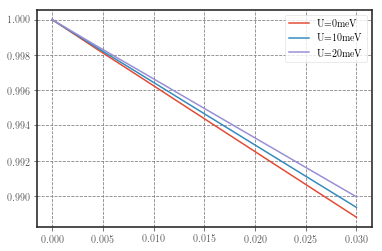

In [6]:
data_77 = calculate_current_slope(binding_energies, alpha_values, lead_SD='flat')

C-V data calculated in 1.5 seconds
C-V data calculated in 3.2 seconds
C-V data calculated in 8.1 seconds
C-V data calculated in 10.0 seconds
C-V data calculated in 18.8 seconds
C-V data calculated in 24.1 seconds
C-V data calculated in 38.1 seconds
C-V data calculated in 59.0 seconds
C-V data calculated in 1.7 seconds
C-V data calculated in 3.4 seconds
C-V data calculated in 7.3 seconds
C-V data calculated in 10.3 seconds
C-V data calculated in 18.6 seconds
C-V data calculated in 24.3 seconds
C-V data calculated in 37.0 seconds
C-V data calculated in 55.0 seconds
C-V data calculated in 1.6 seconds
C-V data calculated in 3.4 seconds
C-V data calculated in 7.6 seconds
C-V data calculated in 10.6 seconds
C-V data calculated in 19.1 seconds
C-V data calculated in 24.7 seconds
C-V data calculated in 38.5 seconds
C-V data calculated in 57.4 seconds


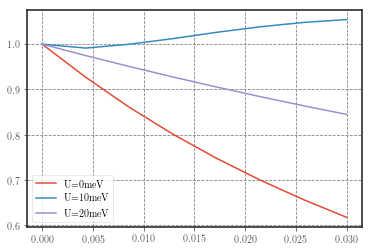

In [6]:
data_77_lor = calculate_current_slope(binding_energies, alpha_values, lead_SD='Lorentzian')

$\frac{2 \Gamma _{\text{downR}} \Gamma _{\text{upEM}} \Gamma _{\text{upL}} \left(\Gamma _{\text{downRU}}+\Gamma _{\text{upLU}}\right)}{\Gamma _{\text{downR}} \left(\Gamma _{\text{upL}} \left(\Gamma _{\text{downEM}}+\Gamma _{\text{upEM}}+\Gamma _{\text{upLU}}\right)+\Gamma _{\text{downRU}} \left(\Gamma _{\text{upEM}}+\Gamma _{\text{upL}}\right)\right)+\Gamma _{\text{upEM}} \Gamma _{\text{upL}} \Gamma _{\text{upLU}}}$

In [2]:
import rate_functions as rf

def analyticalCurrent(rd):
    # rd is a dict with the various rates as key-value pairs
    numer = rd['R_down']*rd['EM_up']*rd['L_up']*(rd['RU_down']+rd['LU_up'])
    
    denom = rd['R_down']*rd['L_up']*(rd['EM_down']+rd['EM_up']+rd['LU_up']) 
    denom += rd['R_down']*rd['RU_down']*(rd['EM_up']+rd['L_up']) + rd['EM_up']*rd['L_up']*rd['LU_up']
    
    return numer/denom
def convert_dicts(rates, element=0):
    return {'R_down': rates['e-0'][element], 'L_up': rates['h-0'][element], 'RU_down': rates['x-h'][element], 
          'EM_down': rates['x-0'][element], 'EM_up': rates['0-x'][element], 'LU_up': rates['x-e'][element]}

reload(rf)
def calculate_current_slope_analytic(binding_energies, alpha_lim=[0,30e-3], 
                                     num_alpha=5, lead_SD='Lorentzian', radiative_lifetime=1):
    data = []
    for BE in binding_energies:
        alpha_values, rates = rf.get_all_rates_states(init_state=0, alpha_lim=alpha_lim, num_alpha=num_alpha,
                       valence_energy=100e-3, binding_energy=BE, radiative_lifetime=radiative_lifetime,
                          mu=700e-3, bias_voltage=0, N_max=10, silent=False, T_C=77., lead_SD=lead_SD)
        rd = convert_dicts(rates)
        I = []
        for i in range(num_alpha):
            rd = convert_dicts(rates, element=i)
            I.append(analyticalCurrent(rd))
        data.append(I)
        plt.plot(alpha_values, np.array(I)/I[0])
    return np.array(data)


# Temperature dependence at finite phonon coupling

C-V data calculated in 8.8 seconds
C-V data calculated in 9.1 seconds
C-V data calculated in 9.7 seconds
C-V data calculated in 14.5 seconds
C-V data calculated in 14.8 seconds
C-V data calculated in 19.4 seconds
C-V data calculated in 19.7 seconds
C-V data calculated in 25.1 seconds
C-V data calculated in 24.9 seconds
C-V data calculated in 31.4 seconds
C-V data calculated in 31.9 seconds
C-V data calculated in 38.8 seconds
C-V data calculated in 11.1 seconds
C-V data calculated in 10.2 seconds
C-V data calculated in 10.1 seconds
C-V data calculated in 15.1 seconds
C-V data calculated in 14.9 seconds
C-V data calculated in 19.4 seconds
C-V data calculated in 19.3 seconds
C-V data calculated in 25.0 seconds
C-V data calculated in 25.2 seconds
C-V data calculated in 31.3 seconds
C-V data calculated in 31.5 seconds
C-V data calculated in 40.0 seconds
C-V data calculated in 10.7 seconds
C-V data calculated in 9.9 seconds
C-V data calculated in 9.9 seconds
C-V data calculated in 15.1 secon

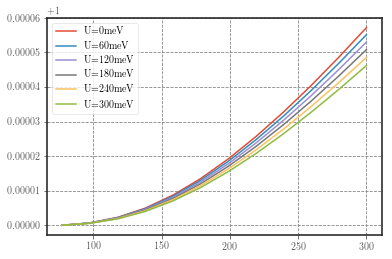

In [14]:
def temperature_current_slope(binding_energies, T_values, lead_SD='Lorentzian'):
    data = []
    for BE in binding_energies:
        I_SC = []
        N_values = [int(n) for n in np.linspace(7,12,len(T_values))]
        for N, T in zip(N_values, T_values):
            PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=BE, radiative_lifetime=1, 
                                  alpha_ph=0.01, mu=700e-3, bias_voltage=0, N=N, silent=True, 
                                  T_C=T, lead_SD=lead_SD, delta_leads=10e-3)
            data_dict = populations_and_current_vs_voltage(PARAMS, x_range=[0.1,0.3],num_voltages=1)
            #print(data_dict['current'])
            I_SC.append(short_current_from_dict(data_dict))
        data.append(np.array(I_SC))
        plt.plot(T_values, np.array(I_SC)/I_SC[0], label='U={}meV'.format(int(BE*1000)))
    plt.legend()
    return np.array(data)

T_values = np.linspace(77,300,12)
binding_energies = np.linspace(0.0, 0.3, 6)
T_data_flat = temperature_current_slope(binding_energies, T_values, lead_SD='flat')


For a flat spectrum, current increases as a function of phonon temperature, regardless of the binding energy. Increasing binding energy just leads to a diminished increase in current. This is perhaps due to the decreasing exciton energy.

C-V data calculated in 10.1 seconds
C-V data calculated in 9.7 seconds
C-V data calculated in 9.8 seconds
C-V data calculated in 16.0 seconds
C-V data calculated in 14.6 seconds
C-V data calculated in 18.9 seconds
C-V data calculated in 19.1 seconds
C-V data calculated in 25.2 seconds
C-V data calculated in 25.2 seconds
C-V data calculated in 31.0 seconds
C-V data calculated in 28.6 seconds
C-V data calculated in 35.4 seconds
C-V data calculated in 10.1 seconds
C-V data calculated in 9.8 seconds
C-V data calculated in 9.1 seconds
C-V data calculated in 13.9 seconds
C-V data calculated in 13.3 seconds
C-V data calculated in 17.6 seconds
C-V data calculated in 17.2 seconds
C-V data calculated in 22.9 seconds
C-V data calculated in 22.2 seconds
C-V data calculated in 28.2 seconds
C-V data calculated in 28.9 seconds
C-V data calculated in 35.0 seconds
C-V data calculated in 9.5 seconds
C-V data calculated in 8.8 seconds
C-V data calculated in 8.8 seconds
C-V data calculated in 13.1 seconds

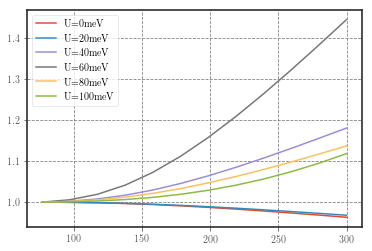

In [16]:
T_values = np.linspace(77,300,12)
binding_energies = np.linspace(0.0, 0.1, 6)
T_data_lor = temperature_current_slope(binding_energies, T_values, lead_SD='Lorentzian')

C-V data calculated in 9.9 seconds
C-V data calculated in 9.2 seconds
C-V data calculated in 9.2 seconds
C-V data calculated in 13.5 seconds
C-V data calculated in 13.6 seconds
C-V data calculated in 17.5 seconds
C-V data calculated in 17.5 seconds
C-V data calculated in 22.8 seconds
C-V data calculated in 22.4 seconds
C-V data calculated in 28.1 seconds
C-V data calculated in 28.1 seconds
C-V data calculated in 35.1 seconds
C-V data calculated in 10.1 seconds
C-V data calculated in 9.9 seconds
C-V data calculated in 9.6 seconds
C-V data calculated in 14.4 seconds
C-V data calculated in 13.9 seconds
C-V data calculated in 17.7 seconds
C-V data calculated in 17.8 seconds
C-V data calculated in 22.4 seconds
C-V data calculated in 22.2 seconds
C-V data calculated in 29.1 seconds
C-V data calculated in 28.8 seconds
C-V data calculated in 36.5 seconds
C-V data calculated in 10.5 seconds
C-V data calculated in 9.2 seconds
C-V data calculated in 9.3 seconds
C-V data calculated in 13.6 seconds

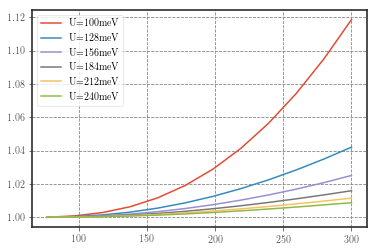

In [17]:
T_values = np.linspace(77,300,12)
binding_energies = np.linspace(0.1, 0.24, 6)
T_data_lor = temperature_current_slope(binding_energies, T_values, lead_SD='Lorentzian')

# Percentage change of rates with increasing $U$

I want to find the point where current *increase* due to phonon coupling is maximised over binding energies. Does this change for

- Fixed: phonon coupling difference, temperature
- Varying continuously: binding energy

for each binding energy I calculate the percent change in current due to inclusion of phonon coupling.

In [3]:
def binding_energy_and_two_alpha(binding_energies, alpha_vals = [0, 0.025], N_vals=[3,8],
                              lead_SD='Lorentzian', valence_energy=100e-3, Omega=50e-3):
    data = []
    for BE in binding_energies:
        I_SC = []
        for N, alpha in zip(N_vals, alpha_vals):
            PARAMS = PARAMS_setup(valence_energy=valence_energy, binding_energy=BE, radiative_lifetime=1, 
                                  alpha_ph=alpha, mu=700e-3, bias_voltage=0, N=N, silent=True, 
                                  T_C=300, lead_SD=lead_SD, delta_leads=10e-3, Omega_ph=Omega)
            data_dict = populations_and_current_vs_voltage(PARAMS, x_range=[0.1,0.3],num_voltages=1)
            #print(data_dict['current'])
            I_SC.append(short_current_from_dict(data_dict))
        data.append(np.array(I_SC))
        #plt.plot(T_values, np.array(I_SC)/I_SC[0], label='U={}meV'.format(int(BE*1000)))
    #plt.legend()
    return np.array(data)

def percent_increase(data):
    percent_incs = []
    for each_BE in data:
        percent_incs.append(100*(each_BE[1]-each_BE[0])/each_BE[0])
    return percent_incs

## $\alpha = 25meV$

In [6]:
binding_energies = np.linspace(0, 0.3, 110)
data = binding_energy_and_two_alpha(binding_energies, alpha_vals = [0, 0.025], N_vals=[3,12],
                              lead_SD='Lorentzian')
PEdata = percent_increase(data)

#plt.plot()

C-V data calculated in 1.5 seconds
C-V data calculated in 34.7 seconds
C-V data calculated in 1.5 seconds
C-V data calculated in 37.4 seconds
C-V data calculated in 1.6 seconds
C-V data calculated in 36.2 seconds
C-V data calculated in 1.5 seconds
C-V data calculated in 36.9 seconds
C-V data calculated in 1.6 seconds
C-V data calculated in 36.7 seconds
C-V data calculated in 1.6 seconds
C-V data calculated in 35.4 seconds
C-V data calculated in 1.5 seconds
C-V data calculated in 34.6 seconds
C-V data calculated in 1.5 seconds
C-V data calculated in 34.6 seconds
C-V data calculated in 1.5 seconds
C-V data calculated in 34.6 seconds
C-V data calculated in 1.5 seconds
C-V data calculated in 34.9 seconds
C-V data calculated in 1.5 seconds
C-V data calculated in 35.0 seconds
C-V data calculated in 1.5 seconds
C-V data calculated in 34.9 seconds
C-V data calculated in 1.5 seconds
C-V data calculated in 34.7 seconds
C-V data calculated in 1.5 seconds
C-V data calculated in 34.7 seconds
C-V da

Text(0.5,0,'U (units of $\\Omega$)')

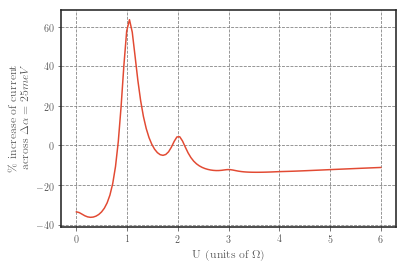

In [13]:
data = load_obj("PEdata_25meV")
PEdata = percent_increase(data)
binding_energies = np.linspace(0, 0.3, len(data))
plt.plot(1000*binding_energies/50, PEdata)
plt.ylabel("\% increase of current\n across " +r"$\Delta\alpha=25meV$")
plt.xlabel(r"U (units of $\Omega$)")

In [10]:
binding_energies = np.linspace(0, 0.3, 110)
data = binding_energy_and_two_alpha(binding_energies, alpha_vals = [0, 0.05], N_vals=[3,13],
                              lead_SD='Lorentzian')
PEdata = percent_increase(data)
save_obj(data, "PEdata_50meV")

C-V data calculated in 1.6 seconds
C-V data calculated in 46.5 seconds
C-V data calculated in 1.6 seconds
C-V data calculated in 45.0 seconds
C-V data calculated in 1.5 seconds
C-V data calculated in 45.2 seconds
C-V data calculated in 1.7 seconds
C-V data calculated in 45.4 seconds
C-V data calculated in 1.5 seconds
C-V data calculated in 45.6 seconds
C-V data calculated in 1.5 seconds
C-V data calculated in 44.7 seconds
C-V data calculated in 1.6 seconds
C-V data calculated in 45.5 seconds
C-V data calculated in 1.6 seconds
C-V data calculated in 45.6 seconds
C-V data calculated in 1.6 seconds
C-V data calculated in 45.3 seconds
C-V data calculated in 1.6 seconds
C-V data calculated in 45.3 seconds
C-V data calculated in 1.5 seconds
C-V data calculated in 44.6 seconds
C-V data calculated in 1.7 seconds
C-V data calculated in 45.5 seconds
C-V data calculated in 1.6 seconds
C-V data calculated in 45.4 seconds
C-V data calculated in 1.5 seconds
C-V data calculated in 45.9 seconds
C-V da

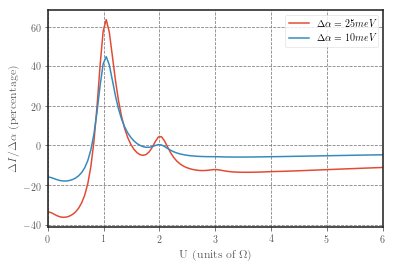

In [35]:
#data2 = load_obj("PEdata_50meV")
 #PEdata2 = percent_increase(data2)

binding_energies = np.linspace(0, 0.3, len(data))
#plt.plot(1000*binding_energies/50, PEdata2, label=r'$\Delta \alpha = 50meV$')
#plt.figure(figsize=(10,8))
plt.plot(1000*binding_energies/50, PEdata, label=r'$\Delta \alpha = 25meV$')
plt.plot(1000*binding_energies/50, PEdata_2, label=r'$\Delta \alpha = 10meV$')
plt.ylabel(r"$\Delta I/\Delta\alpha$ (percentage)")
plt.xlabel(r"U (units of $\Omega$)")
plt.xlim(0,6)
plt.legend()
plt.savefig("resonanceEffect.pdf")

## $\alpha = 10meV$

In [26]:
binding_energies = np.linspace(0, 0.3, 110)
data_2 = binding_energy_and_two_alpha(binding_energies, alpha_vals = [0, 0.01], N_vals=[3,10],
                              lead_SD='Lorentzian')
PEdata_2 = percent_increase(data_2)

C-V data calculated in 1.7 seconds
C-V data calculated in 23.9 seconds
C-V data calculated in 1.6 seconds
C-V data calculated in 22.3 seconds
C-V data calculated in 1.6 seconds
C-V data calculated in 22.2 seconds
C-V data calculated in 1.6 seconds
C-V data calculated in 22.2 seconds
C-V data calculated in 1.5 seconds
C-V data calculated in 24.1 seconds
C-V data calculated in 1.7 seconds
C-V data calculated in 24.6 seconds
C-V data calculated in 1.7 seconds
C-V data calculated in 24.5 seconds
C-V data calculated in 1.6 seconds
C-V data calculated in 24.0 seconds
C-V data calculated in 1.6 seconds
C-V data calculated in 23.7 seconds
C-V data calculated in 1.6 seconds
C-V data calculated in 23.0 seconds
C-V data calculated in 1.5 seconds
C-V data calculated in 24.2 seconds
C-V data calculated in 1.6 seconds
C-V data calculated in 24.6 seconds
C-V data calculated in 1.7 seconds
C-V data calculated in 24.1 seconds
C-V data calculated in 1.6 seconds
C-V data calculated in 24.6 seconds
C-V da

Text(0.5,0,'U (meV)')

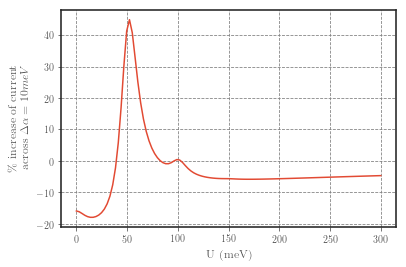

In [27]:
plt.plot(1000*binding_energies, PEdata_2)
plt.ylabel("\% increase of current\n across " +r"$\Delta\alpha=10meV$")
plt.xlabel("U (meV)")

1. understand this behaviour in terms of lead/optical rates
    - Plot these rates in the same fashion
2. Check to see if this same behaviour can occur for when U pushes $\omega_x < \omega_c$
3. ~~Check to see if this same behaviour can occur for $\omega_h \neq U+\Omega$~~
    - $\omega_h$ doesn't matter because rate evaluates at $\omega_x-\omega_h$ so $\omega_h$ cancels


# Resonance behaviour for $\omega_x < \omega_c$, $\alpha=10meV$

In [78]:
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=200e-3, radiative_lifetime=1, 
                                  alpha_ph=0.01, mu=700e-3, bias_voltage=0, N=12, silent=True, 
                                  T_C=300, lead_SD='Lorentzian', delta_leads=10e-3, Omega_ph = 200e-3)
ops = make_expectation_operators(PARAMS) 
dic = build_L(PARAMS, silent=True)
states = separate_energies(dic, PARAMS)
print(states['exciton'][0][0], states['exciton'][1][0])
print(states['electron'][0][0], states['electron'][1][0])
print(states['hole'][0][0], states['hole'][1][0])
print(states['vac'][0][0], states['vac'][1][0])


binding_energies = np.linspace(0, 0.5, 150)
data_3 = binding_energy_and_two_alpha(binding_energies, alpha_vals = [0, 0.05], N_vals=[2,11],
                              lead_SD='Lorentzian', valence_energy=100e-3, Omega=150e-3)
PEdata_3 = percent_increase(data_3)

(11291.7, 12904.800000000025)
(12098.250000000011, 13711.350000000028)
(806.5500000000029, 2419.650000000027)
(0.0, 1613.1000000000001)
C-V data calculated in 0.9 seconds
C-V data calculated in 30.4 seconds
C-V data calculated in 0.8 seconds
C-V data calculated in 30.7 seconds
C-V data calculated in 0.9 seconds
C-V data calculated in 31.5 seconds
C-V data calculated in 0.9 seconds
C-V data calculated in 29.6 seconds
C-V data calculated in 0.8 seconds
C-V data calculated in 28.4 seconds
C-V data calculated in 0.8 seconds
C-V data calculated in 28.3 seconds
C-V data calculated in 0.8 seconds
C-V data calculated in 29.6 seconds
C-V data calculated in 0.9 seconds
C-V data calculated in 29.7 seconds
C-V data calculated in 0.8 seconds
C-V data calculated in 29.7 seconds
C-V data calculated in 0.8 seconds
C-V data calculated in 29.9 seconds
C-V data calculated in 0.8 seconds
C-V data calculated in 29.5 seconds
C-V data calculated in 0.8 seconds
C-V data calculated in 29.3 seconds
C-V data cal

C-V data calculated in 31.6 seconds
C-V data calculated in 0.8 seconds
C-V data calculated in 30.8 seconds
C-V data calculated in 0.8 seconds
C-V data calculated in 30.7 seconds
C-V data calculated in 0.8 seconds
C-V data calculated in 30.0 seconds
C-V data calculated in 0.8 seconds
C-V data calculated in 31.7 seconds
C-V data calculated in 0.9 seconds
C-V data calculated in 31.4 seconds
C-V data calculated in 0.8 seconds
C-V data calculated in 30.0 seconds
C-V data calculated in 0.8 seconds
C-V data calculated in 30.7 seconds
C-V data calculated in 0.9 seconds
C-V data calculated in 31.7 seconds
C-V data calculated in 0.8 seconds
C-V data calculated in 29.9 seconds
C-V data calculated in 0.9 seconds
C-V data calculated in 31.3 seconds
C-V data calculated in 0.8 seconds
C-V data calculated in 30.8 seconds
C-V data calculated in 0.9 seconds
C-V data calculated in 30.5 seconds
C-V data calculated in 0.8 seconds
C-V data calculated in 30.4 seconds
C-V data calculated in 0.8 seconds
C-V da

Text(0.5,0,'U (meV)')

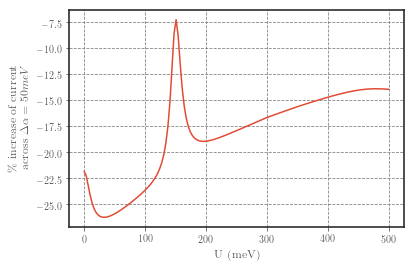

In [79]:

plt.plot(1000*binding_energies, PEdata_3)
plt.ylabel("\% increase of current\n across " +r"$\Delta\alpha=50meV$")
plt.xlabel("U (meV)")

Text(0.5,0,'U (meV)')

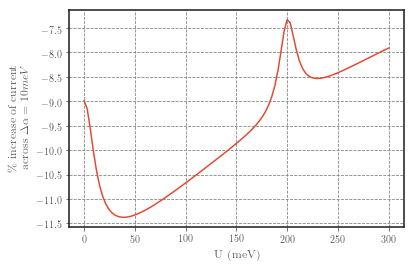

In [75]:
plt.plot(1000*binding_energies, PEdata_3)
plt.ylabel("\% increase of current\n across " +r"$\Delta\alpha=10meV$")
plt.xlabel("U (meV)")

In [56]:
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=50e-3, radiative_lifetime=1, 
                                  alpha_ph=0.025, mu=700e-3, bias_voltage=0, N=8, silent=True, 
                                  T_C=300, lead_SD='Lorentzian', delta_leads=10e-3)
ops = make_expectation_operators(PARAMS) 
dic = build_L(PARAMS, silent=True)
states = separate_energies(dic, PARAMS)
print(states['exciton'][0][0], states['exciton'][1][0])
print(states['electron'][0][0], states['electron'][1][0])
print(states['hole'][0][0], states['hole'][1][0])
print(states['vac'][0][0], states['vac'][1][0])

(12501.52500014116, 12904.80003778233)
(12098.254675262555, 12501.777426079467)
(806.5500001411623, 1209.8250377823322)
(0.0, 403.27500000000003)


# Larger binding energies and larger coupling strengths

What happens if the binding energy is very large? 
    - The enhancement only happens when the higher energies are thermally occupied, which won't happen at room temperatures.
    

In [96]:

PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=75e-3, radiative_lifetime=1, alpha_ph=25e-3, mu=700e-3,
                      bias_voltage=0, N=10,  T_C=300., delta_leads=10e-3, lead_SD='Lorentzian', Omega_ph=50e-3)

dic = build_L(PARAMS, silent=True)
rate_dic_1 = rf.get_rates_state(PARAMS, dic, init_state=0)


PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=75e-3, radiative_lifetime=1, alpha_ph=25e-3, mu=700e-3,
                      bias_voltage=0, N=10,  T_C=300., delta_leads=10e-3, lead_SD='flat', Omega_ph=50e-3)

dic = build_L(PARAMS, silent=True)
rate_dic_2 = rf.get_rates_state(PARAMS, dic, init_state=0)


In [97]:
def print_rates(rate_dic, rate_dic2):
    for key, rate in rate_dic.items():
            if rate!=0.0:
                print(key + ": "+str(rate)+' \t '+str(rate_dic2[key])+' \t '+ str((rate_dic2[key]/rate)))
print_rates(rate_dic_1, rate_dic_2)

x-h: 5.72426830531e-05 	 0.00530899998749 	 92.7454777507
0-x: 0.00103985877502 	 0.00103985877502 	 1.0
x-e: 8.19337092371e-05 	 0.00530899998248 	 64.7962850933
h-0: 0.0043963409409 	 0.00530899999977 	 1.20759515041
e-0: 0.00250205962068 	 0.00530899999951 	 2.12185191577
x-0: 0.0221690757997 	 0.0221690757997 	 1.0


# Percentage change of rates with increasing $\alpha$

In [16]:
def percentage_decrease_of_rates(PARAMS, alpha_vals = [0, 0.025], N_vals=[3,8]):
    PARAMS.update({'alpha_ph' : alpha_vals[0], 'N': N_vals[0]})
    
    dic = build_L(PARAMS, silent=True)
    rate_dic_0 = rf.get_rates_state(PARAMS, dic, init_state=0)
    
    
    PARAMS.update({'alpha_ph' : alpha_vals[1], 'N': N_vals[1]})
    dic = build_L(PARAMS, silent=True)
    rate_dic_1 = rf.get_rates_state(PARAMS, dic, init_state=0)
    
    perc_change_dict = {}
    for key, rate_0 in rate_dic_0.items():
        if rate_0!=0.0:
            perc_change_dict[key] = (rate_0-rate_dic_1[key])/rate_0
            
    for key, value in perc_change_dict.items():
        if value != 0.0:
            print(key+': '+ str(rate_dic_0[key])+'\t decrease: '+str( value))
    return perc_change_dict

print("With no binding energy")
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=50e-3, radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=3,  T_C=300., delta_leads=10e-3, lead_SD='Lorentzian', Omega_ph=50e-3)
pc_0 = percentage_decrease_of_rates(PARAMS, alpha_vals = [0, 0.03], N_vals=[3,14])
print("")
print("With finite binding energy")

PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=100e-3, radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=3, T_C=300., delta_leads=10e-3, lead_SD='Lorentzian', Omega_ph=50e-3)
pc_1 = percentage_decrease_of_rates(PARAMS, alpha_vals = [0, 0.03], N_vals=[3,14])

print(pc_0['x-h']/pc_1['x-h'])
print(pc_0['x-0']/pc_1['x-0'])

"""dic = build_L(PARAMS, silent=True)
rate_dic_single = rf.get_rates_state(PARAMS, dic, init_state=0)

for key, value in rate_dic_single.items():
    if value != 0.0:
        print(key+': '+str( value))"""

With no binding energy
x-h: 0.000204192307692	 decrease: 8.67726159141e-05
0-x: 0.00100038412575	 decrease: 2.05069355275e-06
h-0: 0.005309	 decrease: 2.80893001572e-05
e-0: 0.005309	 decrease: 0.000112352342773
x-e: 0.000204192307692	 decrease: 2.16997087524e-05
x-0: 0.0222363841258	 decrease: 8.01535942123e-07

With finite binding energy
x-h: 5.25643564356e-05	 decrease: 6.46494665291e-05
0-x: 0.00111115102284	 decrease: 2.03583476239e-06
h-0: 0.005309	 decrease: 2.80893001572e-05
e-0: 0.005309	 decrease: 0.000112352342773
x-e: 5.25643564356e-05	 decrease: 1.61758546282e-05
x-0: 0.0223471510228	 decrease: 8.17442647353e-07
1.34220157679
0.980540891424


"dic = build_L(PARAMS, silent=True)\nrate_dic_single = rf.get_rates_state(PARAMS, dic, init_state=0)\n\nfor key, value in rate_dic_single.items():\n    if value != 0.0:\n        print(key+': '+str( value))"

In [15]:
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=50e-3, radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=3, T_C=300., delta_leads=10e-3, lead_SD='Lorentzian', Omega_ph=75e-3)
pc_1 = percentage_decrease_of_rates(PARAMS, alpha_vals = [0, 0.03], N_vals=[3,14])

x-h: 0.000204192307692	 decrease: 6.50208269355e-05
0-x: 0.00100038412575	 decrease: 2.01757887001e-06
h-0: 0.005309	 decrease: 1.91351386667e-05
e-0: 0.005309	 decrease: 7.65384379394e-05
x-e: 0.000204192307692	 decrease: 1.62619206655e-05
x-0: 0.0222363841258	 decrease: 7.99919577241e-07


In [65]:
plt.rcParams['font.size'] = 20

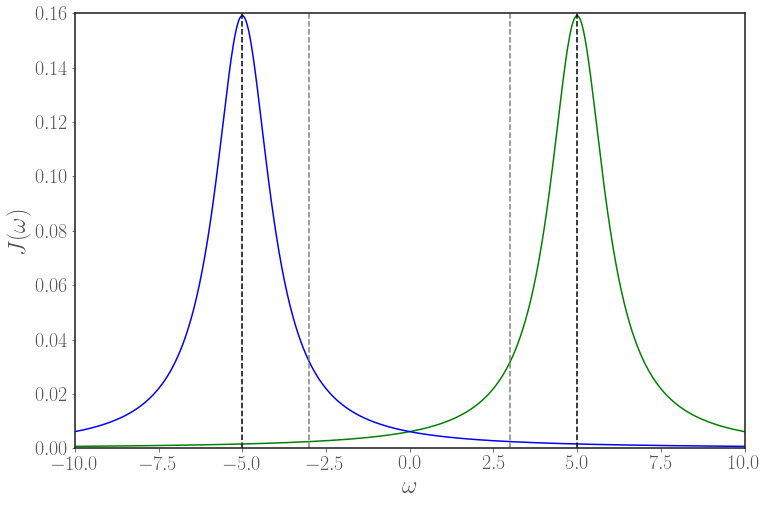

In [70]:
from leads import J_Lorentzian
SD1 = []
SD2 = []
X = np.linspace(-10,10, 1000)
for w in X:
    SD1.append(J_Lorentzian(w, 1, 5, Gamma=1.))
    SD2.append(J_Lorentzian(w, 1, -5, Gamma=1.))
plt.figure(figsize=(12,8))
plt.grid()
plt.plot(X, SD1, color='g')
plt.plot(X, SD2, color='b')



plt.axvline(-5, linestyle='dashed', color='k')
plt.axvline(-3., linestyle='dashed', color='grey')

plt.axvline(5, linestyle='dashed', color='k')
plt.axvline(3., linestyle='dashed', color='grey')

plt.ylim(0, 0.16)
plt.xlim(-10,10)
plt.xlabel(r"$\omega$")
plt.ylabel(r"$J(\omega)$")
plt.savefig("PLOTS/Lorentzians1.pdf")

# Percent change of as a function of Temperature

In [46]:
def separate_energies(dic, PARAMS):
    
    energies, states = dic['H_S'].eigenstates()
    disps = []
    N = PARAMS['N']
    x_CC = (qt.destroy(N)+qt.destroy(N).dag())
    exciton_states = []
    electron_states = []
    hole_states = []
    vac_states = []

    for en, st in zip(energies, states):
        if (st.dag()*tensor(vac_proj, qeye(N))*st).tr() != 0:
            vac_states.append((en, st))

        elif (st.dag()*tensor(hole_proj, qeye(N))*st).tr() != 0:
            hole_states.append((en, st))
            assert((st.dag()*tensor(electron_proj, qeye(N))*st).tr() == 0.)

        elif (st.dag()*tensor(electron_proj, qeye(N))*st).tr() != 0:
            electron_states.append((en, st))
            assert((st.dag()*tensor(hole_proj, qeye(N))*st).tr() == 0.)
        elif (st.dag()*tensor(exciton_proj, qeye(N))*st).tr() != 0:
            exciton_states.append((en, st))
        else:
            print("ERRORS")
        #position = tensor(qeye(4), x_CC)
        #disps.append(abs((st.dag()*position*st).tr())**2)
    assert(len(exciton_states)==len(electron_states))
    assert(len(hole_states)==len(vac_states))
    
    return {'exciton': exciton_states, 'electron': electron_states, 
            'hole': hole_states, 'vac': vac_states}

The lead rates `x-h` and `x-e` (involving exciton dissociation) decrease more rapidly as a function of $\alpha$ the smaller the binding energy. This is probably because the spectral density is more sensitive to changes in frequency near the peak of the Lorentzian (with U>0, the spectral density is sampled further away from the peak). This doesn't take into account the changing thermal occupations. 

I could use flat leads for this (or at least a very wide Lorentzian).

In [45]:
print("With no binding energy")
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0., radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=3,  T_C=77., delta_leads=30e-3)
pc_0 = percentage_change_of_rates(PARAMS, alpha_vals = [0, 0.025], N_vals=[3,8])
print("")
print("With finite binding energy")

PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.1, radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=3, T_C=77., delta_leads=30e-3)
pc_1 = percentage_change_of_rates(PARAMS, alpha_vals = [0, 0.025], N_vals=[3,8])
print(pc_0['x-h']/pc_1['x-h'])

With no binding energy
x-h: 7.15984747068e-05
0-x: 1.7209410199e-06
h-0: 1.79002917191e-05
e-0: 7.15984740021e-05
x-e: 1.79002920362e-05
x-0: 6.54994671667e-07

With finite binding energy
x-h: 5.20254557602e-05
0-x: 1.69647796468e-06
h-0: 1.79002917191e-05
e-0: 7.15984740021e-05
x-e: 1.30105122233e-05
x-0: 6.81202225223e-07
1.37622003807


In [48]:
print("With no binding energy")
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0., radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=3,  T_C=77., delta_leads=45e-3)
pc_0 = percentage_change_of_rates(PARAMS, alpha_vals = [0, 0.025], N_vals=[3,8])
print("")
print("With finite binding energy")

PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.1, radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=3, T_C=77., delta_leads=45e-3)
pc_1 = percentage_change_of_rates(PARAMS, alpha_vals = [0, 0.025], N_vals=[3,8])
print(pc_0['x-h']/pc_1['x-h'])

With no binding energy
x-h: 5.37984234825e-05
0-x: 1.7209410199e-06
h-0: 1.34498987433e-05
e-0: 5.37984222869e-05
x-e: 1.34498991498e-05
x-0: 6.54994671667e-07

With finite binding energy
x-h: 4.96314855311e-05
0-x: 1.69647796468e-06
h-0: 1.34498987433e-05
e-0: 5.37984222869e-05
x-e: 1.24088087213e-05
x-0: 6.81202225223e-07
1.08395755047


In [76]:
50e-3

0.05

In [20]:
print("With no binding energy")
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.0, radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=3,  T_C=77., delta_leads=2000e-3)
pc_0 = percentage_change_of_rates(PARAMS, alpha_vals = [0, 0.03], N_vals=[3,7])
print("")
print("With finite binding energy")

PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.1, radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=3, T_C=77., delta_leads=2000e-3)
pc_1 = percentage_change_of_rates(PARAMS, alpha_vals = [0, 0.03], N_vals=[3,7])
print(pc_0['x-h']/pc_1['x-h'])

With no binding energy
x-h: 7.29975592384e-08
0-x: 2.06519028595e-06
h-0: 1.82473603563e-08
e-0: 7.29994485153e-08
x-e: 1.82486716099e-08
x-0: 7.85993585626e-07

With finite binding energy
x-h: 3.63132844577e-07
0-x: 2.03583476259e-06
h-0: 1.82473603563e-08
e-0: 7.29994485153e-08
x-e: 9.07825353707e-08
x-0: 8.17442647508e-07
0.201021638027


# Puzzling phenomenon!
If the lead SD width is equal to $50meV$ then the rate of decrease of current is the same for $U=0$ and $U=100meV$. For this to occur, the
$J_{\nu}(\omega) = \frac{1}{2\pi}\frac{\Gamma\delta_{\nu}^2}{(\omega-\omega_{\nu})^2+\delta_{\nu}^2}$

$1/\sqrt{U}$

In [90]:
1/np.sqrt(0.1)

3.162277660168379

In [91]:
1/(np.sqrt(200))

0.07071067811865475

In [2]:
print("With no binding energy")
BE = 0.2
delta = 1/(2*np.sqrt(BE*1000))
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0., radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=3,  T_C=77., delta_leads=0.07071)
pc_0 = percentage_change_of_rates(PARAMS, alpha_vals = [0, 0.025], N_vals=[3,8])
print("")
print("With finite binding energy")

PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.2, radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=3, T_C=77., delta_leads=0.07071)
pc_1 = percentage_change_of_rates(PARAMS, alpha_vals = [0, 0.025], N_vals=[3,8])
print(pc_0['x-h']/pc_1['x-h'])

With no binding energy


NameError: name 'percentage_change_of_rates' is not defined

In [ ]:
0.999910190097

In [13]:
print("With no binding energy")
BE = 0.3
delta = 300.
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0., radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=3,  T_C=77., delta_leads=delta)
pc_0 = percentage_change_of_rates(PARAMS, alpha_vals = [0, 0.025], N_vals=[3,8])
print("")
print("With finite binding energy")

PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.3, radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=3, T_C=77., delta_leads=delta)
pc_1 = percentage_change_of_rates(PARAMS, alpha_vals = [0, 0.025], N_vals=[3,8])
print(pc_0['x-h']/pc_1['x-h'])

With no binding energy
x-h: 3.62596089902e-12
0-x: 1.7209410199e-06
h-0: 6.64449084272e-13
e-0: 1.01358301422e-12
x-e: 1.4238194663e-12
x-0: 6.54994671667e-07

With finite binding energy
x-h: 3.60849964224e-11
0-x: 1.64388750573e-06
h-0: 6.64449084272e-13
e-0: 1.01358301422e-12
x-e: 9.53886477227e-12
x-0: 7.37273597244e-07
0.100483892435


In [ ]:
1.01716354679